In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
# сохраняю target в отдельную переменную
df['y'] = df['y'].replace('yes', 1)
df['y'] = df['y'].replace('no', 0)
Y = df['y']

In [5]:
type_obj = [i for i in df.columns if df[i].dtype == 'O']
type_obj

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [6]:
# проверяю на наличие пропусков в df
is_null_dict = df.isna().sum().to_dict()
null_columns = {k:v for k,v in is_null_dict.items() if v > 0}
null_columns

{'age': 588, 'balance': 5, 'month': 5}

In [7]:
# группировка по ID переменных типа object 
job = df.groupby('job')[['ID']].count()
marital = df.groupby('marital')[['ID']].count()
education = df.groupby('education')[['ID']].count()
default = df.groupby('default')[['ID']].count()
housing = df.groupby('housing')[['ID']].count()
loan = df.groupby('loan')[['ID']].count()
contact = df.groupby('contact')[['ID']].count()
poutcome = df.groupby('poutcome')[['ID']].count()
month = df.groupby('month')[['ID']].count()

Числовые переменные в df: ['ID', 'age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'y']


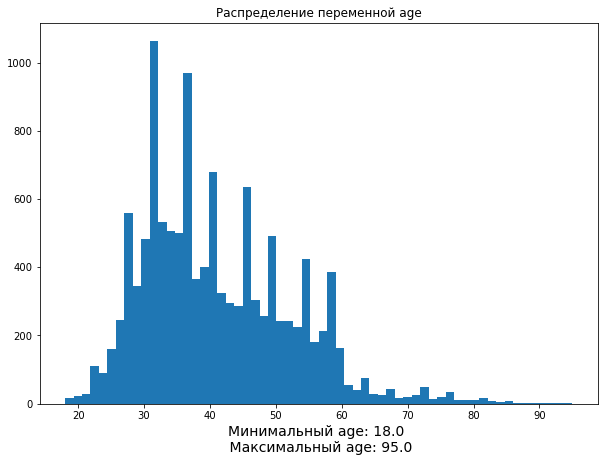

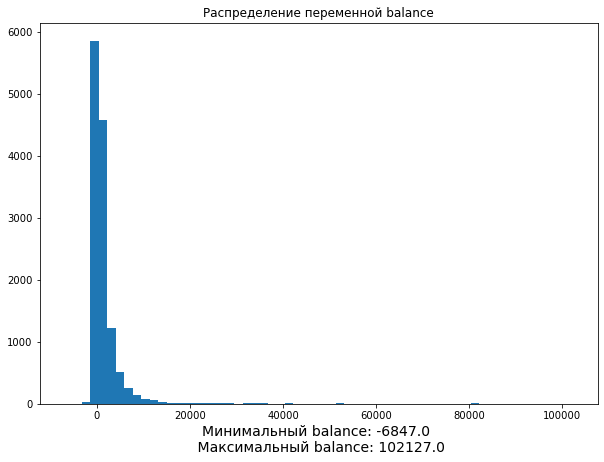

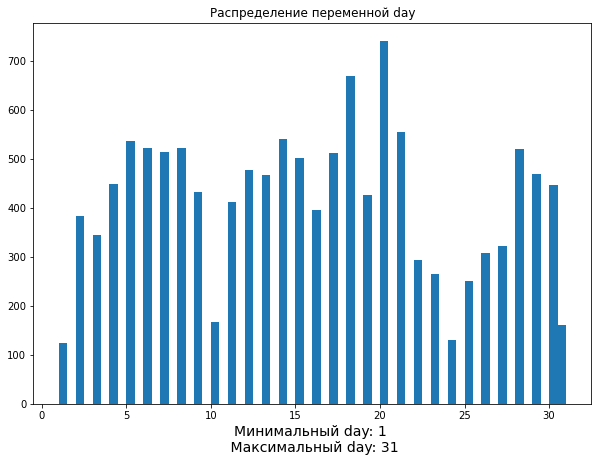

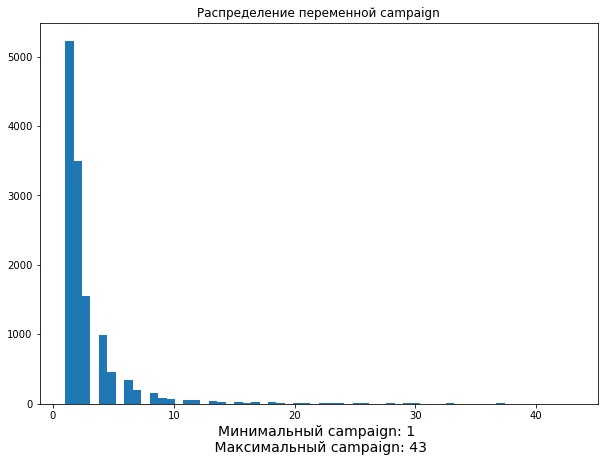

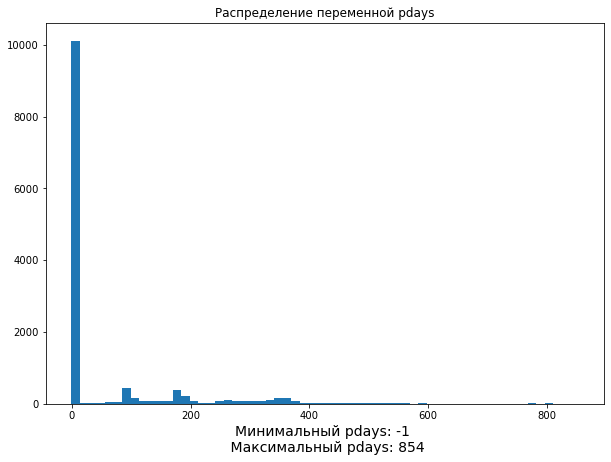

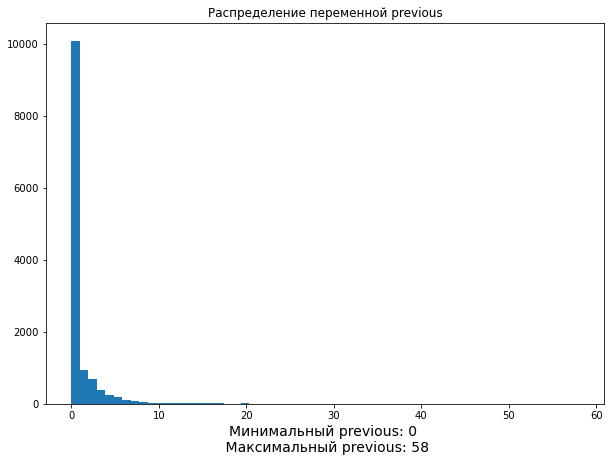

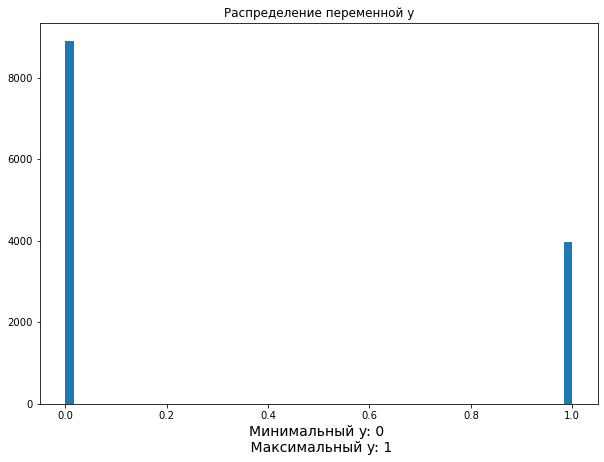

In [8]:
# Распределение числовых переменных
num_obj = [i for i in df.columns if (df[i].dtype == 'int') or (df[i].dtype == 'float')]
print('Числовые переменные в df:', num_obj)
for i in num_obj[1:]:
    plt.figure(figsize=(10, 7))
    plt.title(f'Распределение переменной {i}')
    plt.hist(df[i], bins=60)
    plt.xlabel(f'Минимальный {i}: {df[i].min()} \n Максимальный {i}: {df[i].max()}', fontsize= 14)

In [9]:
# DataFrame с переменной 'balance' и 'y'
df_balance = pd.DataFrame(df['balance'])
df_for_stat_test = pd.concat((df_balance, Y), axis=1)

# среднее переменной 'balance' сгрупированной по переменной 'y'
df_for_stat_test.groupby('y').mean()

,balance
y,
0,1333.559789
1,1817.723721


In [10]:
# однофакторный ANOVA тест для выборок с у == 1 и у == 0
from scipy.stats import f_oneway
print(f_oneway(df_for_stat_test[df_for_stat_test['y'] == 1]['balance'], df_for_stat_test[df_for_stat_test['y'] == 0]['balance'].fillna(0)))
# -> различия статистически значимы

F_onewayResult(statistic=59.24171571005837, pvalue=1.4959531894122055e-14)


In [11]:
# отрицательный баланс в отдельную переменную
df['balance_negative'] = df['balance'][(df['balance'] < 0)]
df['balance_negative'] = df['balance_negative'].fillna(0)

# меняю -1 на 0
df.loc[(df['pdays'] < 0), 'pdays'] = 0

# нормирую переменную баланс
df.loc[(df['balance'] < 0), 'balance'] = 0
df['balance'] = df['balance'][df['balance'] > 0].apply(lambda x: np.log(x))

In [12]:
# группировка по ID переменных типа object 
job = df.groupby('job')[['ID']].count()
marital = df.groupby('marital')[['ID']].count()
education = df.groupby('education')[['ID']].count()
default = df.groupby('default')[['ID']].count()
housing = df.groupby('housing')[['ID']].count()
loan = df.groupby('loan')[['ID']].count()
contact = df.groupby('contact')[['ID']].count()
poutcome = df.groupby('poutcome')[['ID']].count()
month = df.groupby('month')[['ID']].count()

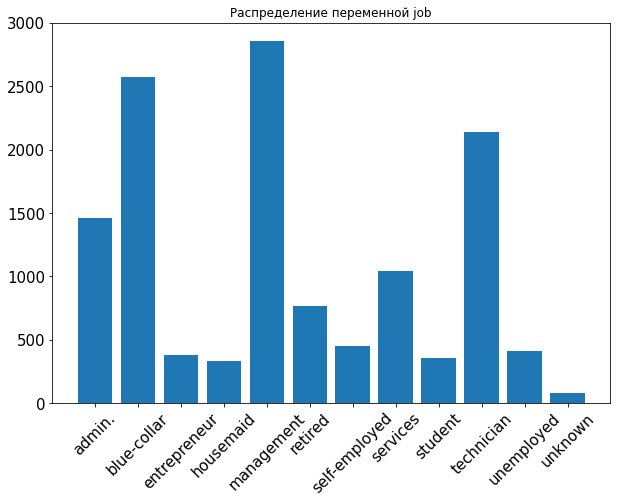

In [13]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной job')
plt.bar(job.index, job["ID"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

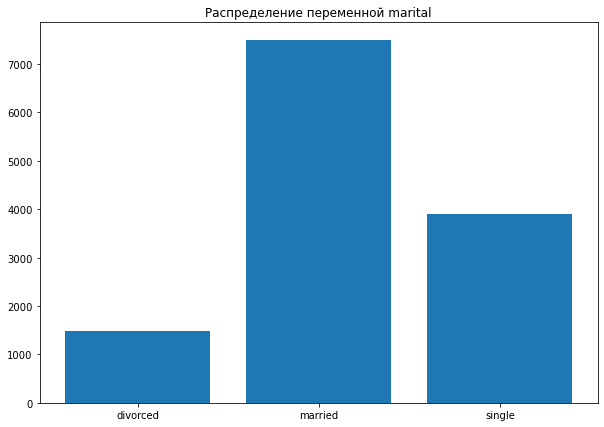

In [14]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной marital')
plt.bar(marital.index, marital["ID"]);

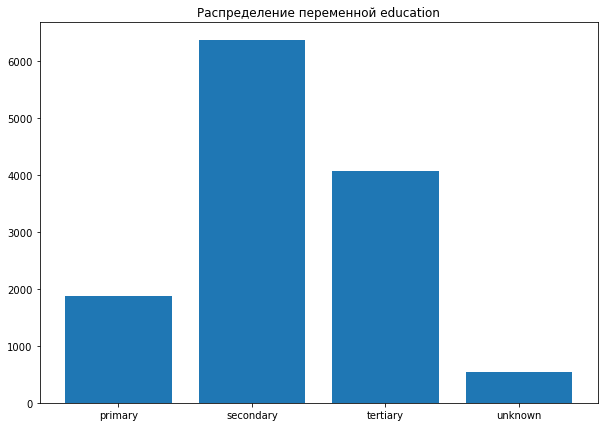

In [15]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной education')
plt.bar(education.index, education["ID"]);

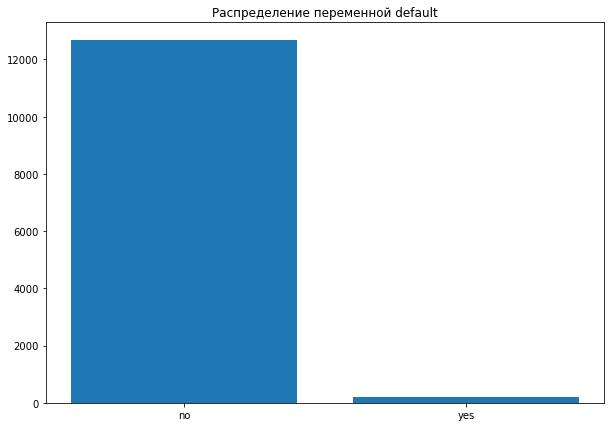

In [16]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной default')
plt.bar(default.index, default["ID"]);

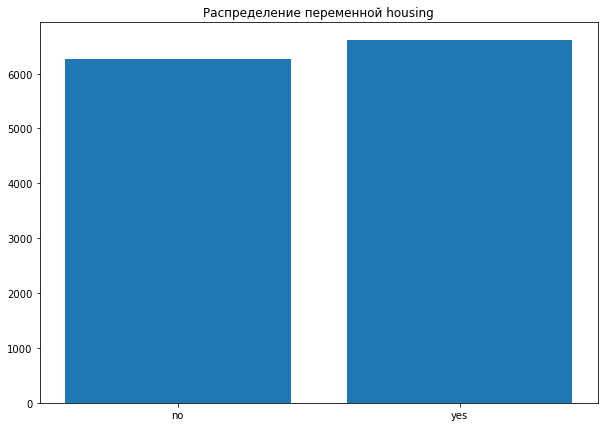

In [17]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной housing')
plt.bar(housing.index, housing["ID"]);

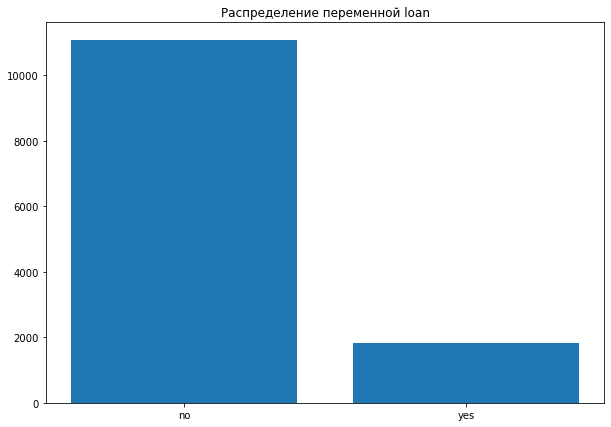

In [18]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной loan')
plt.bar(loan.index, loan["ID"]);

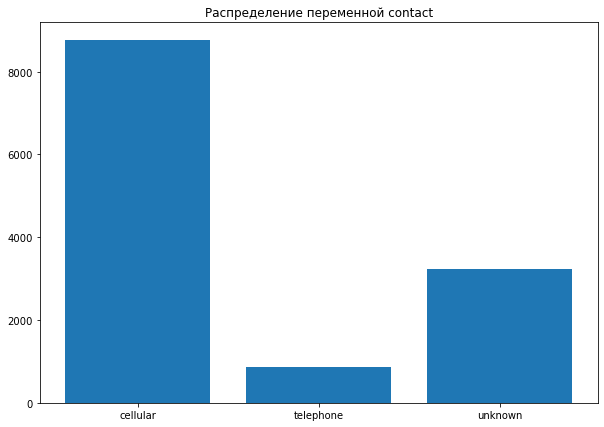

In [19]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной contact')
plt.bar(contact.index, contact["ID"]);

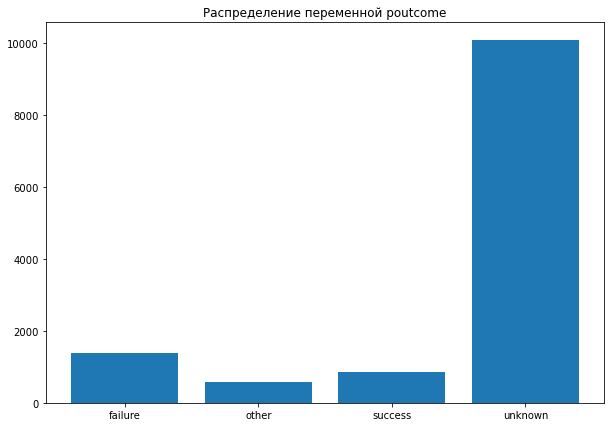

In [20]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной poutcome')
plt.bar(poutcome.index, poutcome["ID"]);

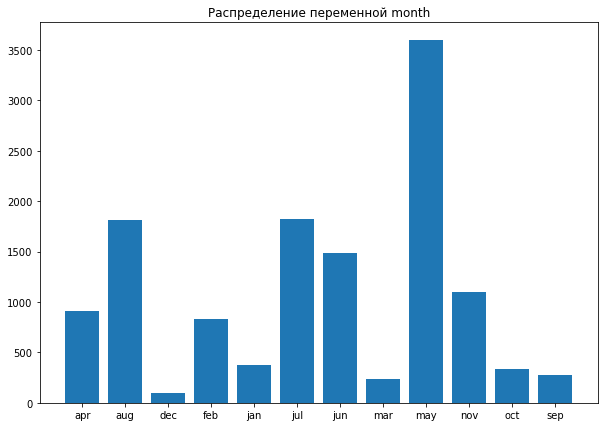

In [21]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной month')
plt.bar(month.index, month["ID"]);

In [22]:
# пропущеное значение месяца заменяю на unknown
df['month'] = df['month'].fillna('unknown')

In [23]:
is_null_dict = df.isna().sum().to_dict()
null_columns = {k:v for k, v in is_null_dict.items() if v > 0}
null_columns

{'age': 588, 'balance': 1857}

### Исследование данных

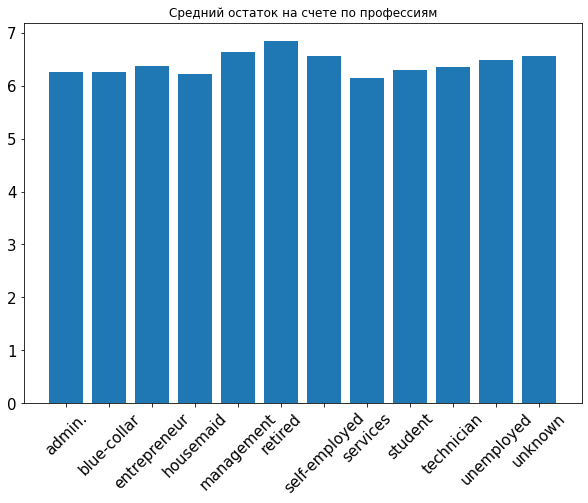

In [24]:
job_balance = df.groupby('job')[['balance']].mean()

plt.figure(figsize=(10, 7))
plt.title('Средний остаток на счете по профессиям')
plt.bar(job_balance.index, job_balance["balance"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

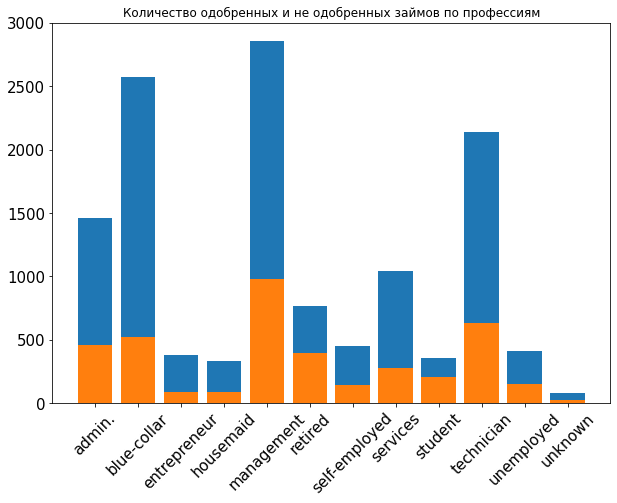

In [25]:
df_y_1 = df[df['y'] == 1] # одобренные займы

job_y = df_y_1.groupby('job')[['y']].count()
job_y1 = df.groupby('job')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных и не одобренных займов по профессиям')
plt.bar(job_y1.index, job_y1["y"])
plt.bar(job_y.index, job_y["y"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

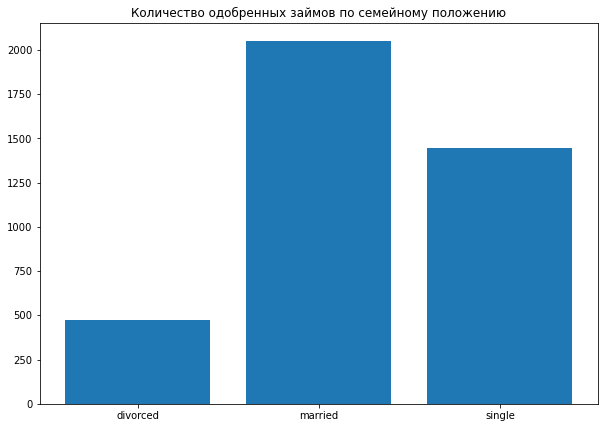

In [26]:
marital_y1 = df_y_1.groupby('marital')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов по семейному положению')
plt.bar(marital_y1.index, marital_y1["y"]);

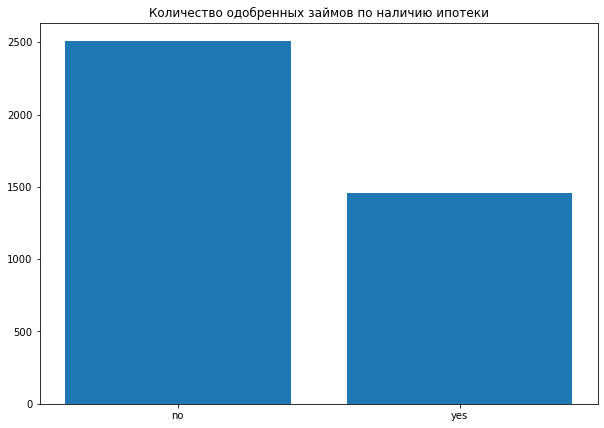

In [27]:
housing_y1 = df_y_1.groupby('housing')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов по наличию ипотеки')
plt.bar(housing_y1.index, housing_y1["y"]);

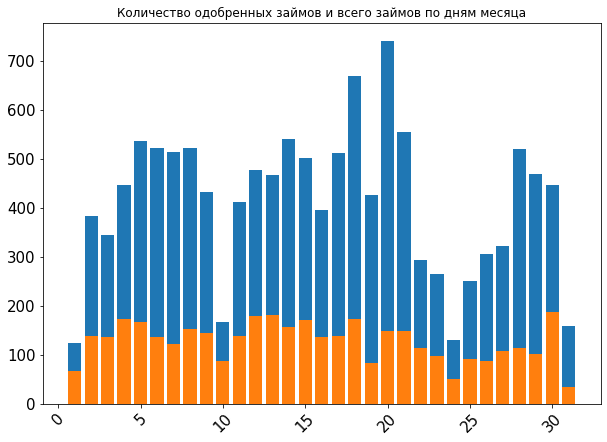

In [28]:
day_ID = df.groupby('day')[['ID']].count()
day_ID1 = df_y_1.groupby('day')[['ID']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов и всего займов по дням месяца')
plt.bar(day_ID.index, day_ID["ID"])
plt.bar(day_ID1.index, day_ID1["ID"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

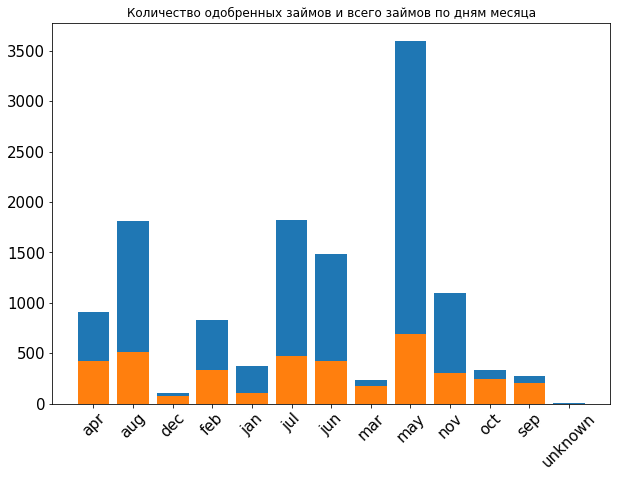

In [29]:
month_ID = df.groupby('month')[['ID']].count()
month_ID1 = df_y_1.groupby('month')[['ID']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов и всего займов по дням месяца')
plt.bar(month_ID.index, month_ID["ID"])
plt.bar(month_ID1.index, month_ID1["ID"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

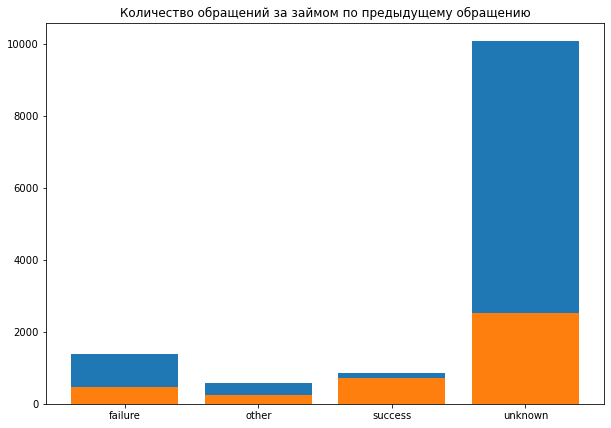

In [30]:
poutcome_y = df.groupby('poutcome')[['y']].count()
poutcome_y1 = df_y_1.groupby('poutcome')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество обращений за займом по предыдущему обращению')
plt.bar(poutcome_y.index, poutcome_y["y"]);
plt.bar(poutcome_y1.index, poutcome_y1["y"]);

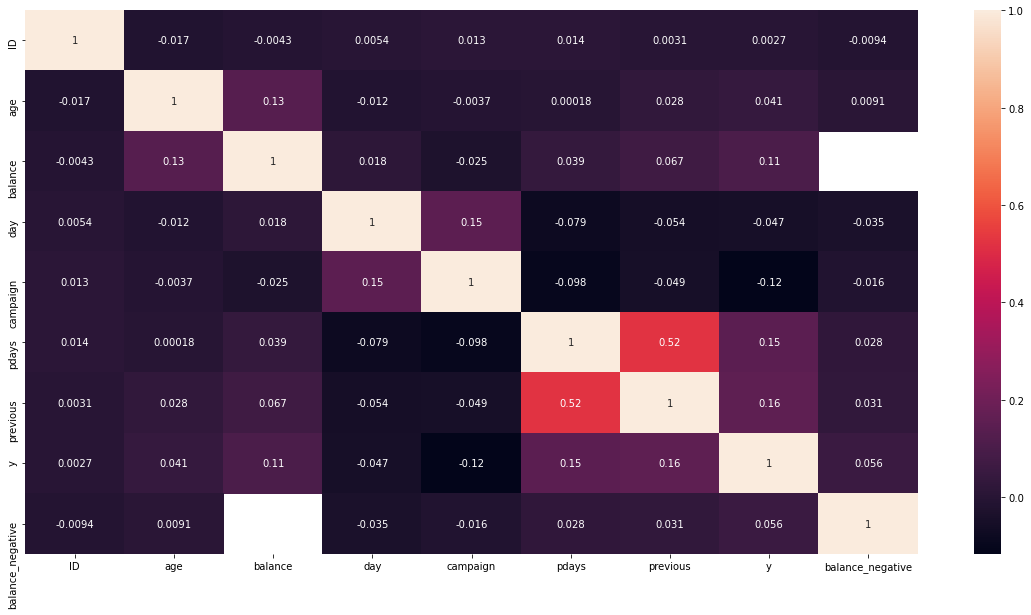

In [31]:
# числовые признаки
num_obj = [i for i in df.columns if (df[i].dtype == 'int') or (df[i].dtype == 'float')]

# корреляционная таблица для числовых переменных
int_float_features = df[num_obj]
corr_matrix_int_float = int_float_features.corr()
figure, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix_int_float, annot=True, ax=ax);

In [32]:
# НОВЫЕ ПРИЗНАКИ
# средний баланс клиентов по прошлому результату 
mean_bal_pou = df.groupby('poutcome')['balance'].mean().to_dict()
df['mean_balance_poutcome'] = df['poutcome'].map(mean_bal_pou)

In [33]:
# средний баланс клиентов по виду работы
mean_bal_job = df.groupby('job')['balance'].mean().to_dict()
df['mean_balance_job'] = df['job'].map(mean_bal_job)

In [34]:
# средний баланс клиентов по семейному положению
mean_bal_mar = df.groupby('marital')['balance'].mean().to_dict()
df['mean_balance_marital'] = df['marital'].map(mean_bal_mar)

In [35]:
# средний баланс клиентов по образованию
mean_bal_edu = df.groupby('education')['balance'].mean().to_dict()
df['mean_balance_education'] = df['education'].map(mean_bal_edu)

In [36]:
# среднее количество контактов от прошлого исхода
mean_cam_pou = df.groupby('poutcome')['campaign'].mean().to_dict()
df['mean_campaign_poutcome'] = df['poutcome'].map(mean_cam_pou)

In [37]:
# среднее количество дней последнего контакта от прошлого исхода
mean_pdays_pou = df.groupby('poutcome')['pdays'].mean().to_dict()
df['mean_pdays_poutcome'] = df['poutcome'].map(mean_pdays_pou)

In [38]:
# средний возраст от исхода
mean_age_pou = df.groupby('poutcome')['age'].mean().to_dict()
df['mean_age_poutcome'] = df['poutcome'].map(mean_age_pou)

In [39]:
# среднее количество контактов от исхода
mean_pre_pou = df.groupby('poutcome')['previous'].mean().to_dict()
df['mean_previous_poutcome'] = df['poutcome'].map(mean_pre_pou)

In [40]:
# средний баланс от наличия ипотеки
mean_bal_house = df.groupby('housing')['balance'].mean().to_dict()
df['mean_balance_housing'] = df['housing'].map(mean_bal_house)

In [41]:
# средний баланс по наличию личного кредита
mean_bal_loan = df.groupby('loan')['balance'].mean().to_dict()
df['mean_balance_loan'] = df['loan'].map(mean_bal_loan)

In [42]:
# средний баланс по наличию кредита по умолчанию
mean_bal_def = df.groupby('default')['balance'].mean().to_dict()
df['mean_balance_default'] = df['default'].map(mean_bal_def)

In [43]:
df_baseline = pd.get_dummies(df, columns = type_obj)

# заполняю пропуски при помощи IterativeImputer

imp = IterativeImputer(max_iter= 5, random_state= 42)
df_iter_imput_baseline = pd.DataFrame(imp.fit_transform(df_baseline))

# возвращаю названия колонкам после заполнения пропусков 
for dq_c, df_c in zip(df_iter_imput_baseline.columns.to_list(), df_baseline.columns.to_list()):
    df_iter_imput_baseline.rename(columns = {dq_c : df_c}, inplace = True)

In [44]:
df_iter_imput_baseline.columns[7:]

Index(['y', 'balance_negative', 'mean_balance_poutcome', 'mean_balance_job',
       'mean_balance_marital', 'mean_balance_education',
       'mean_campaign_poutcome', 'mean_pdays_poutcome', 'mean_age_poutcome',
       'mean_previous_poutcome', 'mean_balance_housing', 'mean_balance_loan',
       'mean_balance_default', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_no

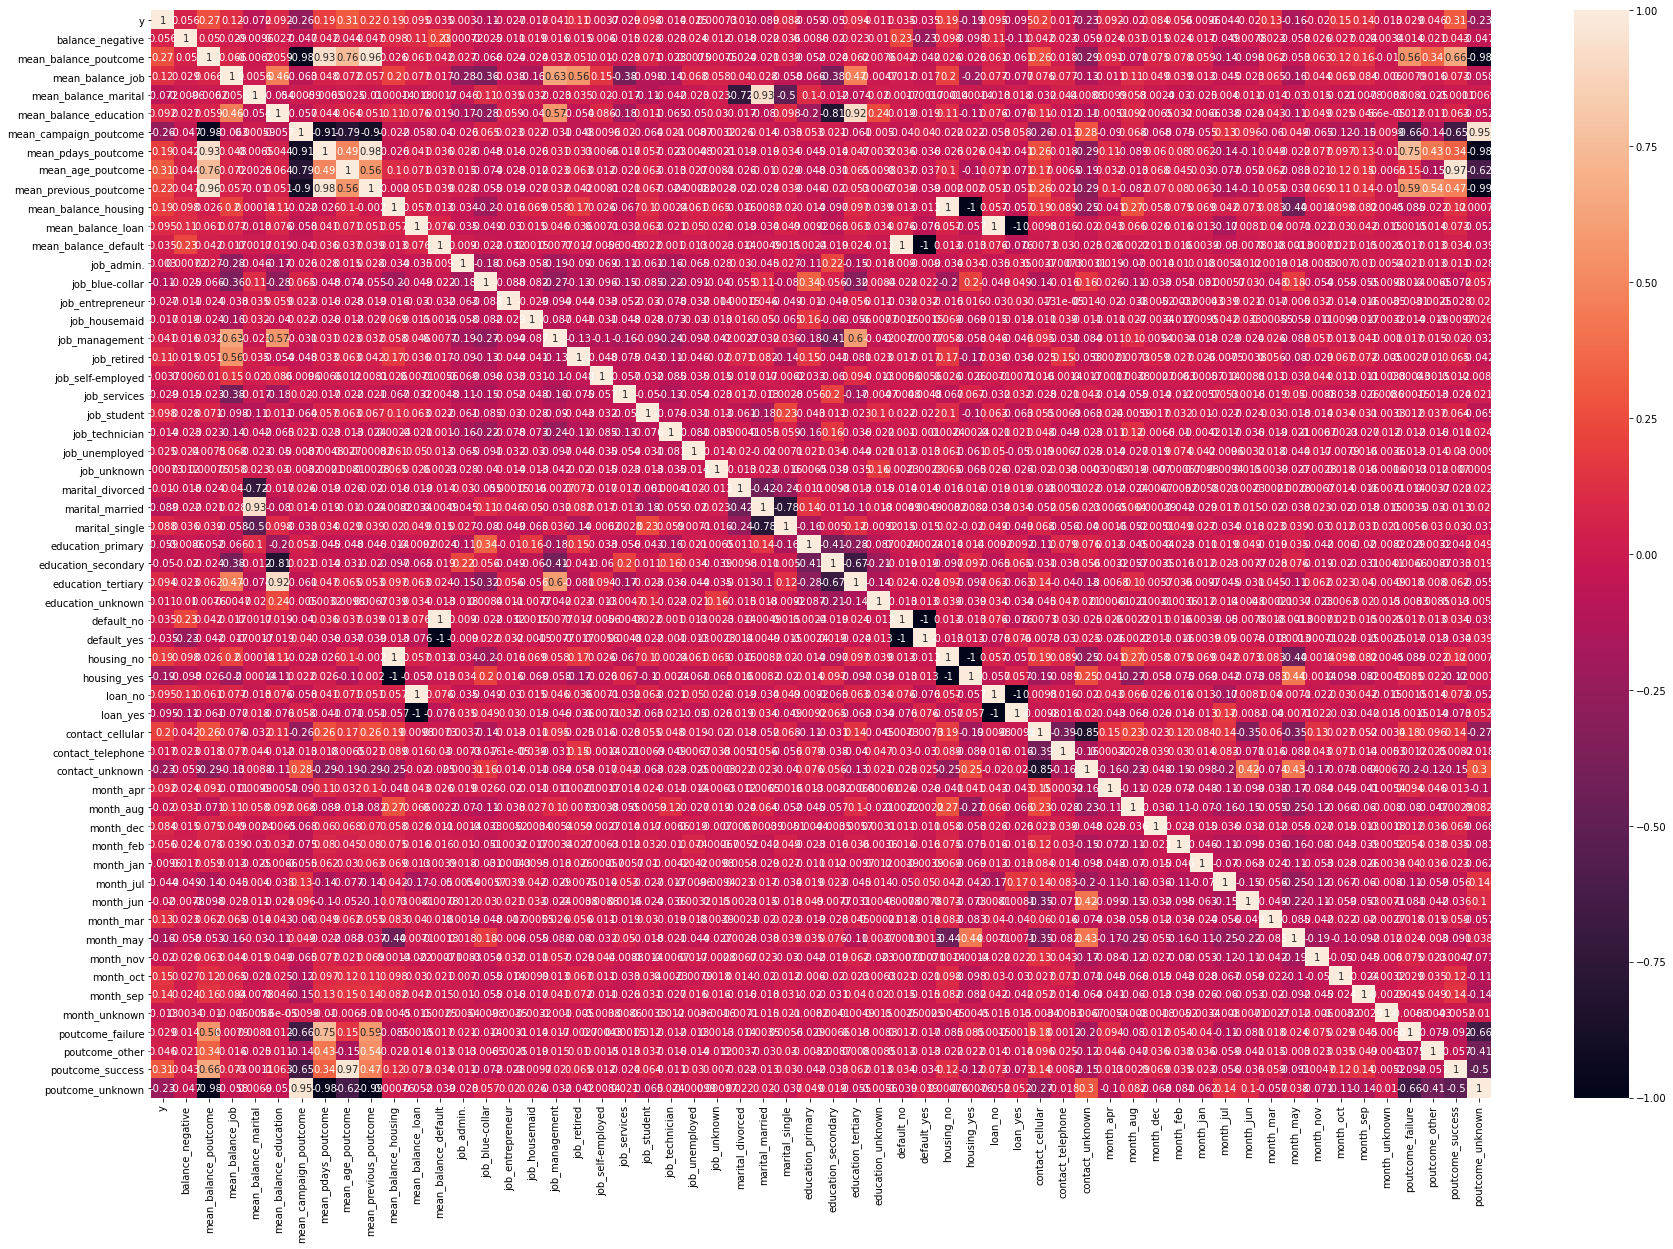

In [45]:
# корреляционная таблица для категориальных данных
obj_features = df_iter_imput_baseline[df_iter_imput_baseline.columns[7:]]

corr_matrix_obj = obj_features.corr()
figure, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_matrix_obj, annot=True, ax=ax);

In [46]:
# признаки с наивысшей корреляцией к Y 
print(abs(obj_features.corr()['y']).sort_values(ascending=False)[1:12].index.to_list())
print(abs(int_float_features.corr()['y']).sort_values(ascending=False)[1:4].index.to_list())

['poutcome_success', 'mean_age_poutcome', 'mean_balance_poutcome', 'mean_campaign_poutcome', 'poutcome_unknown', 'contact_unknown', 'mean_previous_poutcome', 'contact_cellular', 'housing_no', 'housing_yes', 'mean_balance_housing']
['previous', 'pdays', 'campaign']


In [47]:
# удаляю target из выборки
df_iter_imput_baseline = df_iter_imput_baseline.drop(['y'], axis = 1)

# разбиваю выборку на valid и train
X_train, X_valid, y_train, y_valid = train_test_split(df_iter_imput_baseline, Y, random_state=42)

rfe = RFE(estimator = GradientBoostingClassifier(learning_rate= 0.01), n_features_to_select= 50)

rfe.fit(X_train, y_train)
print(f"Train ROC-AUC score: {round(roc_auc_score(rfe.predict(X_train), y_train), 2)}.\nValid ROC-AUC score: {round(roc_auc_score(rfe.predict(X_valid), y_valid), 2)}.")

Train ROC-AUC score: 0.79.
Valid ROC-AUC score: 0.79.


In [48]:
# признаки, которые отобрал RFE
rfe_df = pd.DataFrame(rfe.ranking_, index= df_iter_imput_baseline.columns, columns= ['Rank']).sort_values(by= 'Rank', ascending=True)
rfe_df

,Rank
ID,1
poutcome_failure,1
poutcome_success,1
marital_married,1
default_yes,1
...,...
job_unemployed,11
month_dec,12
job_unknown,13
poutcome_unknown,14


In [49]:
cat_clt = CatBoostClassifier(learning_rate=0.005, n_estimators = 500, l2_leaf_reg = 4, depth= 4, verbose=False)
cat_clt.fit(X_train, y_train)
print("train acc:", roc_auc_score(cat_clt.predict(X_train), y_train))
print("valid acc:", roc_auc_score(cat_clt.predict(X_valid), y_valid))

train acc: 0.7747209828056718
valid acc: 0.7591719177042211


In [50]:
st = StackingClassifier(estimators=[
                                    ('st_gbc', GradientBoostingClassifier(learning_rate=0.01)), 
                                    ('st_cbc', CatBoostClassifier(learning_rate=0.1, n_estimators = 1500, l2_leaf_reg = 2, depth=3, loss_function='Logloss', verbose=False))
                                   ], 
                        final_estimator=GradientBoostingClassifier(learning_rate=0.01))
st.fit(X_train, y_train)
print(f"Train ROC-AUC score: {round(roc_auc_score(st.predict(X_train), y_train), 2)}.\nValid ROC-AUC score: {round(roc_auc_score(st.predict(X_valid), y_valid), 2)}.")

Train ROC-AUC score: 0.84.
Valid ROC-AUC score: 0.76.


In [51]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)
valid_accuracy = []
for train_idx, valid_idx in kf.split(np.array(df_iter_imput_baseline), Y):
    clf = GradientBoostingClassifier(learning_rate=0.12, criterion='squared_error', subsample = 0.5, 
                                     loss='exponential', min_samples_split=6)
    clf.fit(np.array(df_iter_imput_baseline)[train_idx], Y[train_idx])
    valid_accuracy.append(roc_auc_score(Y[valid_idx], clf.predict(np.array(df_iter_imput_baseline)[valid_idx])))
print(f'Mean roc_auc_score for GradientBoostingClassifier:{np.mean(valid_accuracy)}')

Mean roc_auc_score for GradientBoostingClassifier:0.688957228245275


In [52]:
valid_accuracy = []
for train_idx, valid_idx in kf.split(np.array(df_iter_imput_baseline), Y):
    clf = CatBoostClassifier(learning_rate=0.1, n_estimators = 1500, l2_leaf_reg = 2, depth=3, loss_function='Logloss', verbose=False)
    clf.fit(np.array(df_iter_imput_baseline)[train_idx], Y[train_idx])
    valid_accuracy.append(roc_auc_score(Y[valid_idx], clf.predict(np.array(df_iter_imput_baseline)[valid_idx])))
print(f'Mean roc_auc_score for CatBoostClassifier:{np.mean(valid_accuracy)}')

Mean roc_auc_score for CatBoostClassifier:0.7047455107636634


In [102]:

parameters = {
    'loss': ['log_loss', 'exponential'], 
    'learning_rate':[0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [3, 2, 4]
    }
gbc = GradientBoostingClassifier()
gscv = GridSearchCV(gbc, parameters, verbose=False, scoring= 'roc_auc')

gscv.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [3, 2, 4], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='roc_auc', verbose=False)

In [103]:
print(f"Train ROC-AUC score for Grid Search: {round(roc_auc_score(gscv.predict(X_train), y_train), 2)}.\nValid ROC-AUC score for Grid Search: {round(roc_auc_score(gscv.predict(X_valid), y_valid), 2)}.")

Train ROC-AUC score for Grid Search: 0.83.
Valid ROC-AUC score for Grid Search: 0.77.
